Arquivos e linhas alteradas por faixa (LOG)
1. Análise de Tamanho e Complexidade dos Pull Requests
A hipótese aqui é que desenvolvedores mais experientes (Faixa A) podem submeter PRs mais atômicos e focados, enquanto os novatos (Faixa E) podem submeter mudanças maiores e menos coesas.
Métricas a extrair:
Linhas de código por PR: Calcule a soma de additions e deletions para cada PR. Compare a média e a mediana entre as faixas.
Número de arquivos por PR: Use counts.files. Desenvolvedores experientes tendem a modificar menos arquivos em um único PR para manter o escopo limitado?
Distribuição do "churn": Analise a proporção entre additions e deletions. Um PR que só adiciona código (um novo recurso) é diferente de um que refatora (muitas adições e deleções)? Essa proporção muda com a experiência?
Visualizações sugeridas:
Box plots comparando o número de linhas de código e o número de arquivos por PR para cada faixa de desenvolvedor (A a E). Isso mostrará não apenas a média, mas também a dispersão e os outliers.

Mapeando desenvolvedores para faixas...
Mapeamento concluído. 975 mapeamentos de desenvolvedor/repo encontrados.
Iniciando extração de métricas dos Pull Requests...
Extração concluída. 73132 PRs com mudanças processados.

--- Análise Estatística por Faixa ---
       media_linhas_alteradas  mediana_linhas_alteradas  \
faixa                                                     
E                      492.10                      10.0   
D                     6761.38                      18.0   
C                     3290.82                      26.0   
B                     1476.27                      37.0   
A                     1515.85                      46.0   

       media_arquivos_alterados  mediana_arquivos_alterados  total_prs  
faixa                                                                   
E                          7.61                         1.0        192  
D                         20.53                         1.0        491  
C                         22.17   

/tmp/ipykernel_26308/1736124004.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], data=df_prs, x='faixa', y='lines_changed',
/tmp/ipykernel_26308/1736124004.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], data=df_prs, x='faixa', y='files_changed',


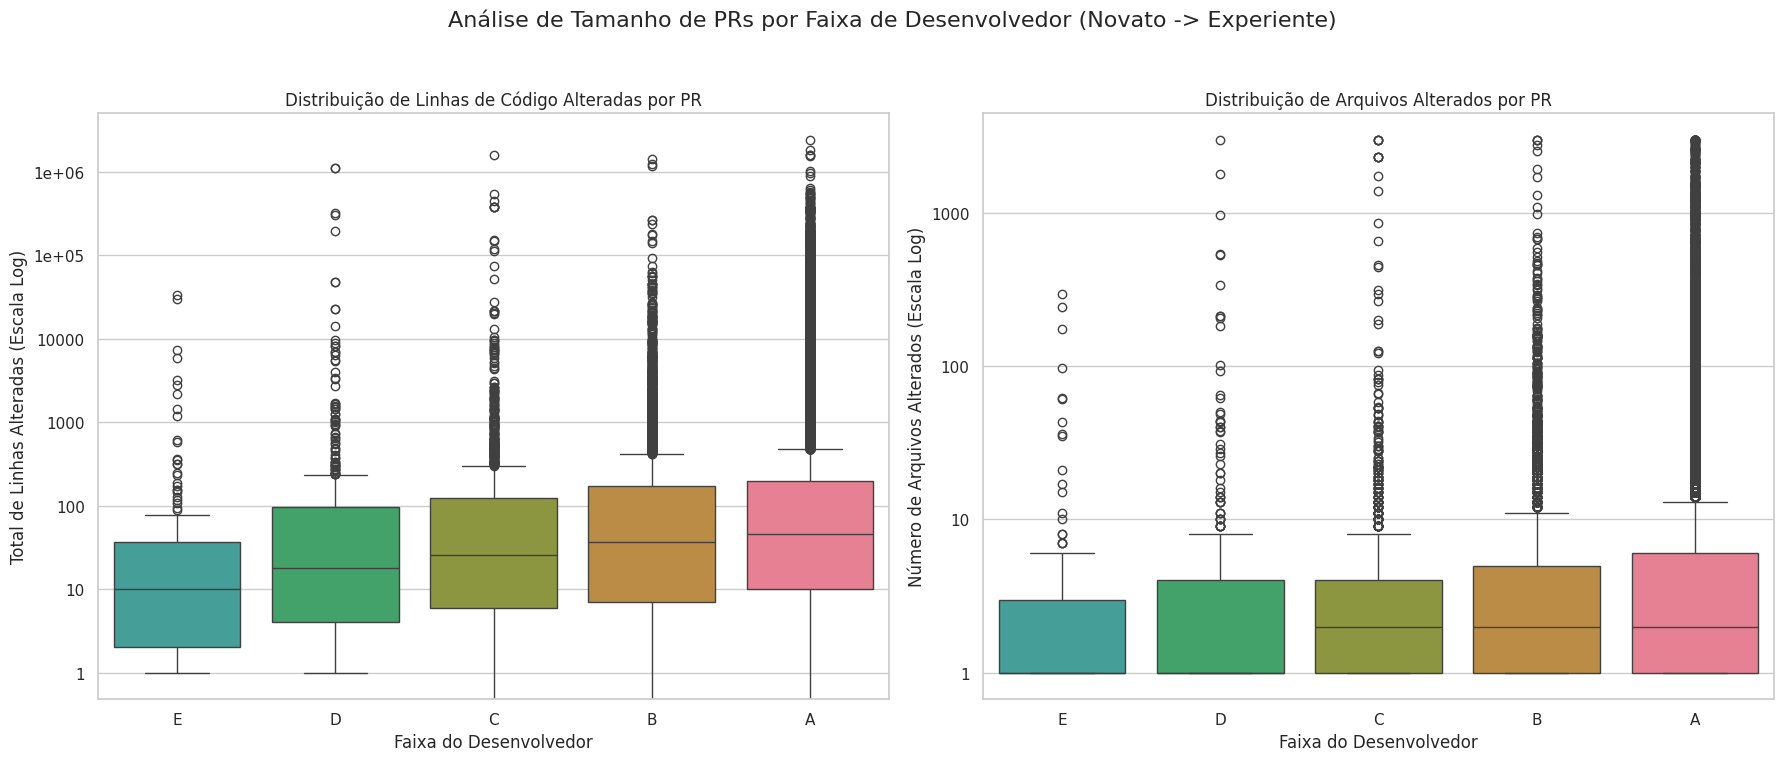


Análise concluída. Gráfico salvo como 'analise_faixas_prs_boxplots.png'.


In [1]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter

# --- 1. Configuração Inicial ---
BASE_DIR = 'repositories-mined'
FAIXA_ORDER = ['E', 'D', 'C', 'B', 'A']


def load_dev_faixas(base_dir):
    """
    Carrega o mapeamento de desenvolvedor para faixa a partir dos arquivos sample-devs.jsonl.
    """
    dev_map = {}
    print("Mapeando desenvolvedores para faixas...")
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file == 'sample-devs.jsonl':
                filepath = os.path.join(root, file)
                with open(filepath, 'r', encoding='utf-8') as f:
                    for line in f:
                        try:
                            dev_data = json.loads(line)
                            # --- CORRIGIDO: Usando chave composta para robustez ---
                            repo_key = dev_data['repo'].lower().replace('/', '-')
                            author_key = dev_data['author'].lower()
                            dev_map[(repo_key, author_key)] = dev_data['faixa']
                        except (json.JSONDecodeError, KeyError):
                            print(f"Aviso: Linha mal formatada em {filepath}: {line.strip()}")
    print(f"Mapeamento concluído. {len(dev_map)} mapeamentos de desenvolvedor/repo encontrados.")
    return dev_map


def extract_pr_metrics(base_dir, dev_faixa_map):
    """
    Extrai métricas de cada PR e associa ao seu autor e faixa.
    """
    all_pr_data = []
    print("Iniciando extração de métricas dos Pull Requests...")

    for root, dirs, files in os.walk(base_dir):
        if root.endswith(os.path.sep + 'results'):
            for file in files:
                if file.endswith('.json'):
                    filepath = os.path.join(root, file)
                    try:
                        with open(filepath, 'r', encoding='utf-8') as f:
                            data = json.load(f)

                        # --- CORRIGIDO: Usando chave composta para lookup ---
                        repo_key = data['repo'].lower().replace('/', '-')
                        author_key = data['author'].lower()
                        faixa = dev_faixa_map.get((repo_key, author_key))

                        if not faixa:
                            continue

                        additions = sum(f.get('additions', 0) for f in data.get('files', []))
                        deletions = sum(f.get('deletions', 0) for f in data.get('files', []))
                        total_loc_changed = additions + deletions
                        num_files = data.get('counts', {}).get('files', 0)

                        # Apenas PRs com alguma mudança são considerados
                        if total_loc_changed > 0 or num_files > 0:
                            all_pr_data.append({
                                'author': data['author'], 'faixa': faixa, 'repo': data['repo'],
                                'pr_number': data['pr_number'], 'lines_changed': total_loc_changed,
                                'files_changed': num_files, 'additions': additions, 'deletions': deletions
                            })
                    except (json.JSONDecodeError, KeyError) as e:
                        print(f"Aviso: Erro ao processar o arquivo {filepath}. Erro: {e}")

    print(f"Extração concluída. {len(all_pr_data)} PRs com mudanças processados.")
    return pd.DataFrame(all_pr_data)


# --- 2. Execução da Análise ---
if __name__ == "__main__":
    dev_map = load_dev_faixas(BASE_DIR)

    if not dev_map:
        print("Nenhum desenvolvedor encontrado nos arquivos 'sample-devs.jsonl'. Encerrando.")
    else:
        df_prs = extract_pr_metrics(BASE_DIR, dev_map)

        if df_prs.empty:
            print("Nenhum dado de PR foi extraído. Verifique a estrutura dos diretórios. Encerrando.")
        else:
            # --- 3. Análise de Dados e Estatísticas (sem alterações) ---
            print("\n--- Análise Estatística por Faixa ---")
            summary = df_prs.groupby('faixa').agg(
                media_linhas_alteradas=('lines_changed', 'mean'),
                mediana_linhas_alteradas=('lines_changed', 'median'),
                media_arquivos_alterados=('files_changed', 'mean'),
                mediana_arquivos_alterados=('files_changed', 'median'),
                total_prs=('pr_number', 'count')
            ).reindex(FAIXA_ORDER)
            print(summary.round(2))

            # --- 4. Visualização dos Dados (COM A NOVA PALETA) ---
            print("\nGerando visualizações com a paleta 'husl'...")

            # --- MODIFICADO: Definindo a paleta de cores consistente ---
            cores_husl = sns.color_palette("husl", 8)
            faixas_originais = ['A', 'B', 'C', 'D', 'E']
            paleta_consistente = dict(zip(faixas_originais, cores_husl))
            # --- FIM DA MODIFICAÇÃO ---

            sns.set_theme(style="whitegrid")
            fig, axes = plt.subplots(1, 2, figsize=(18, 8))
            fig.suptitle('Análise de Tamanho de PRs por Faixa de Desenvolvedor (Novato -> Experiente)', fontsize=16)

            # Gráfico 1: Box plot para Linhas de Código Alteradas
            sns.boxplot(ax=axes[0], data=df_prs, x='faixa', y='lines_changed',
                        order=FAIXA_ORDER, palette=paleta_consistente) # <-- MODIFICADO
            axes[0].set_yscale('log')
            axes[0].set_title('Distribuição de Linhas de Código Alteradas por PR')
            axes[0].set_xlabel('Faixa do Desenvolvedor')
            axes[0].set_ylabel('Total de Linhas Alteradas (Escala Log)')
            formatter = LogFormatter(10, labelOnlyBase=False)
            axes[0].yaxis.set_major_formatter(formatter)

            # Gráfico 2: Box plot para Arquivos Alterados
            sns.boxplot(ax=axes[1], data=df_prs, x='faixa', y='files_changed',
                        order=FAIXA_ORDER, palette=paleta_consistente) # <-- MODIFICADO
            axes[1].set_yscale('log')
            axes[1].set_title('Distribuição de Arquivos Alterados por PR')
            axes[1].set_xlabel('Faixa do Desenvolvedor')
            axes[1].set_ylabel('Número de Arquivos Alterados (Escala Log)')
            axes[1].yaxis.set_major_formatter(formatter)

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.savefig('analise_faixas_prs_boxplots.png')
            plt.show()

            print("\nAnálise concluída. Gráfico salvo como 'analise_faixas_prs_boxplots.png'.")

#2 Porcentagem de PRs aceitos vs recusados por faixa

Mapeando desenvolvedores para faixas...
Mapeamento concluído. 975 desenvolvedores encontrados.
Iniciando extração de métricas dos Pull Requests...
Extração concluída. 72801 PRs fechados processados.

--- Análise Proporcional de PRs Aceitos vs. Recusados/Fechados ---
Proporção de PRs por faixa e status (%):
is_merged  Aceitos  Recusados/Fechados
faixa                                 
E            57.59               42.41
D            60.49               39.51
C            70.28               29.72
B            73.57               26.43
A            82.27               17.73


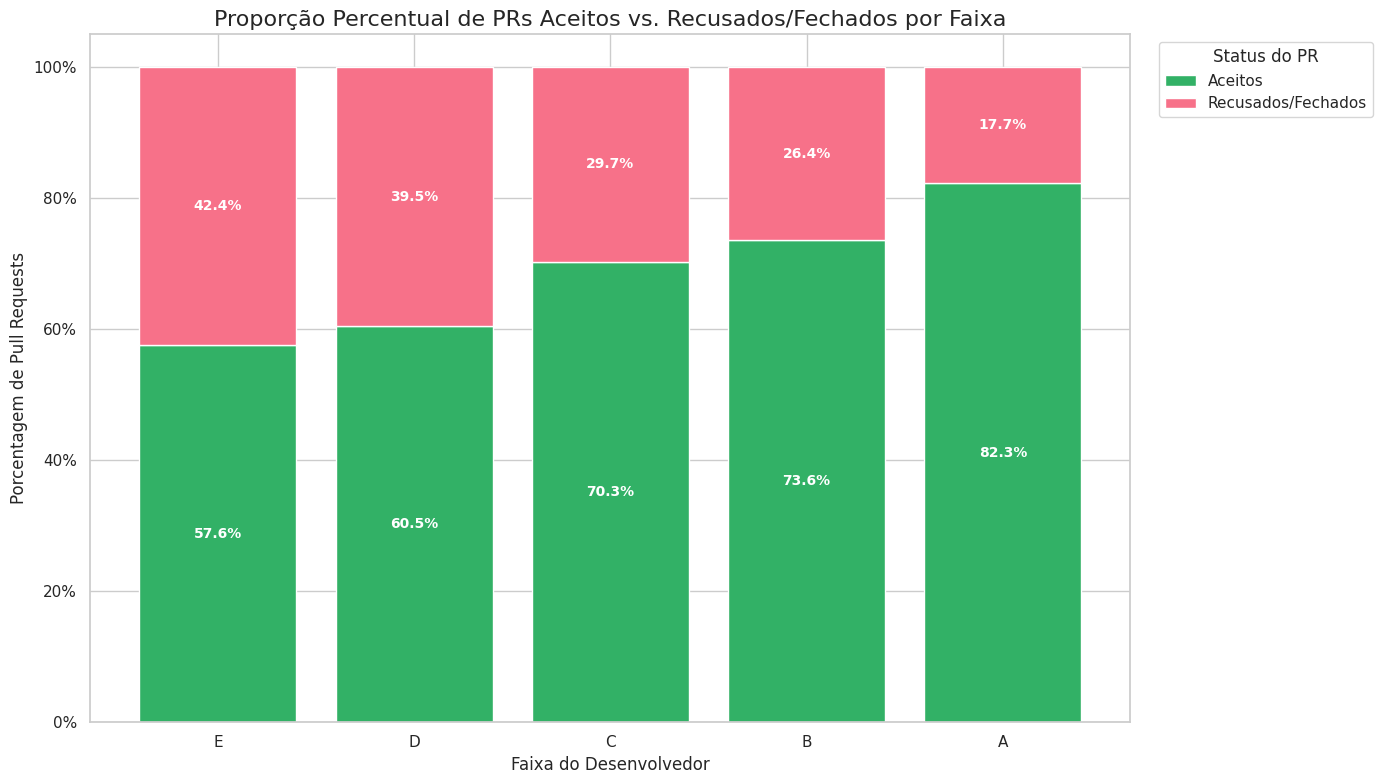


Análise concluída. Gráfico percentual salvo como 'analise_prs_status_percentual.png'.


In [2]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# --- 1. Configuração Inicial ---
BASE_DIR = 'repositories-mined'
FAIXA_ORDER = ['E', 'D', 'C', 'B', 'A']


def load_dev_faixas(base_dir):
    """
    Carrega o mapeamento de desenvolvedor para faixa a partir dos arquivos sample-devs.jsonl.
    """
    dev_map = {}
    print("Mapeando desenvolvedores para faixas...")
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file == 'sample-devs.jsonl':
                filepath = os.path.join(root, file)
                with open(filepath, 'r', encoding='utf-8') as f:
                    for line in f:
                        try:
                            dev_data = json.loads(line)
                            # Normalizando o nome do repo para a chave, caso seja necessário
                            repo_key = dev_data['repo'].lower().replace('/', '-')
                            # Usando uma tupla (repo, author) para a chave para evitar colisões
                            key = (repo_key, dev_data['author'].lower())
                            dev_map[key] = dev_data['faixa']
                        except (json.JSONDecodeError, KeyError):
                            print(f"Aviso: Linha mal formatada em {filepath}: {line.strip()}")
    print(f"Mapeamento concluído. {len(dev_map)} desenvolvedores encontrados.")
    return dev_map


def extract_pr_metrics(base_dir, dev_faixa_map):
    """
    Extrai métricas de cada PR e associa ao seu autor e faixa.
    """
    all_pr_data = []
    print("Iniciando extração de métricas dos Pull Requests...")

    for root, _, files in os.walk(base_dir):
        if root.endswith(os.path.sep + 'results'):
            for file in files:
                if file.endswith('.json'):
                    filepath = os.path.join(root, file)
                    try:
                        with open(filepath, 'r', encoding='utf-8') as f:
                            data = json.load(f)

                        # Chave para lookup no mapa de desenvolvedores
                        repo_key = data['repo'].lower().replace('/', '-')
                        author_key = data['author'].lower()
                        lookup_key = (repo_key, author_key)

                        faixa = dev_faixa_map.get(lookup_key)
                        if not faixa:
                            continue

                        additions = sum(f.get('additions', 0) for f in data.get('files', []))
                        deletions = sum(f.get('deletions', 0) for f in data.get('files', []))
                        total_loc_changed = additions + deletions
                        num_files = data.get('counts', {}).get('files', 0)

                        # Considera apenas PRs fechados para a análise de aceitação
                        if data.get('state') == 'closed':
                            is_merged = data.get('merged_at') is not None
                            all_pr_data.append({
                                'author': data['author'],
                                'faixa': faixa,
                                'repo': data['repo'],
                                'pr_number': data['pr_number'],
                                'lines_changed': total_loc_changed,
                                'files_changed': num_files,
                                'additions': additions,
                                'deletions': deletions,
                                'is_merged': is_merged
                            })
                    except (json.JSONDecodeError, KeyError) as e:
                        print(f"Aviso: Erro ao processar o arquivo {filepath}. Erro: {e}")

    print(f"Extração concluída. {len(all_pr_data)} PRs fechados processados.")
    return pd.DataFrame(all_pr_data)


# --- 2. Execução da Análise ---
if __name__ == "__main__":
    dev_map = load_dev_faixas(BASE_DIR)

    if not dev_map:
        print("Nenhum desenvolvedor encontrado nos arquivos 'sample-devs.jsonl'. Encerrando.")
    else:
        df_prs_all = extract_pr_metrics(BASE_DIR, dev_map)

        if df_prs_all.empty:
            print("Nenhum dado de PR válido para análise foi encontrado. Encerrando.")
        else:
            # --- 3. e 4. Box Plots (seção omitida para focar na mudança solicitada) ---

            # --- 5. GRÁFICO DE BARRAS 100% EMPILHADAS (COM MODIFICAÇÕES) ---
            print("\n--- Análise Proporcional de PRs Aceitos vs. Recusados/Fechados ---")

            counts = df_prs_all.groupby(['faixa', 'is_merged']).size().unstack(fill_value=0)
            counts_pct = counts.div(counts.sum(axis=1), axis=0) * 100

            counts_pct.rename(columns={True: 'Aceitos', False: 'Recusados/Fechados'}, inplace=True)
            counts_pct = counts_pct.reindex(FAIXA_ORDER)
            # Garantindo a ordem das colunas para que 'Aceitos' venha primeiro
            counts_pct = counts_pct[['Aceitos', 'Recusados/Fechados']]

            print("Proporção de PRs por faixa e status (%):")
            print(counts_pct.round(2))

            # --- INÍCIO DA MODIFICAÇÃO ---
            # 1. Definir a paleta de cores 'husl' conforme solicitado.
            cores_husl = sns.color_palette("husl", 8)
            # 2. Selecionar duas cores distintas para as duas categorias.
            #    Vamos pegar cores que contrastam bem, por exemplo a primeira e a quarta.
            cores_para_plot = [cores_husl[3], cores_husl[0]] # Um verde e um vermelho/rosa

            # 3. Criar o gráfico de barras 100% empilhadas usando as cores definidas
            ax = counts_pct.plot(
                kind='bar',
                stacked=True,
                figsize=(14, 8),
                color=cores_para_plot,  # Substituindo 'colormap' por 'color'
                width=0.8
            )
            # --- FIM DA MODIFICAÇÃO ---

            # 5. Adicionar os rótulos de porcentagem
            for container in ax.containers:
                ax.bar_label(container, label_type='center', fmt='{:.1f}%', color='white', fontsize=10,
                             fontweight='bold')

            ax.yaxis.set_major_formatter(PercentFormatter())

            plt.title('Proporção Percentual de PRs Aceitos vs. Recusados/Fechados por Faixa', fontsize=16)
            plt.xlabel('Faixa do Desenvolvedor', fontsize=12)
            plt.ylabel('Porcentagem de Pull Requests', fontsize=12)
            plt.xticks(rotation=0)
            plt.legend(title='Status do PR', bbox_to_anchor=(1.02, 1), loc='upper left')

            plt.tight_layout()
            plt.savefig('analise_prs_status_percentual.png')
            plt.show()

            print("\nAnálise concluída. Gráfico percentual salvo como 'analise_prs_status_percentual.png'.")

#3 correlaçoes


1. Carregando classificação dos desenvolvedores...
-> Mapeamento de 975 desenvolvedores carregado.

2. Processando TODOS os Pull Requests (aceitos e rejeitados)...


Repos: 100%|██████████| 13/13 [00:02<00:00,  5.63it/s]


-> Foram processados 72801 PRs fechados de desenvolvedores da amostra.

3. Analisando Taxa de Aceitação vs. Número de Arquivos...


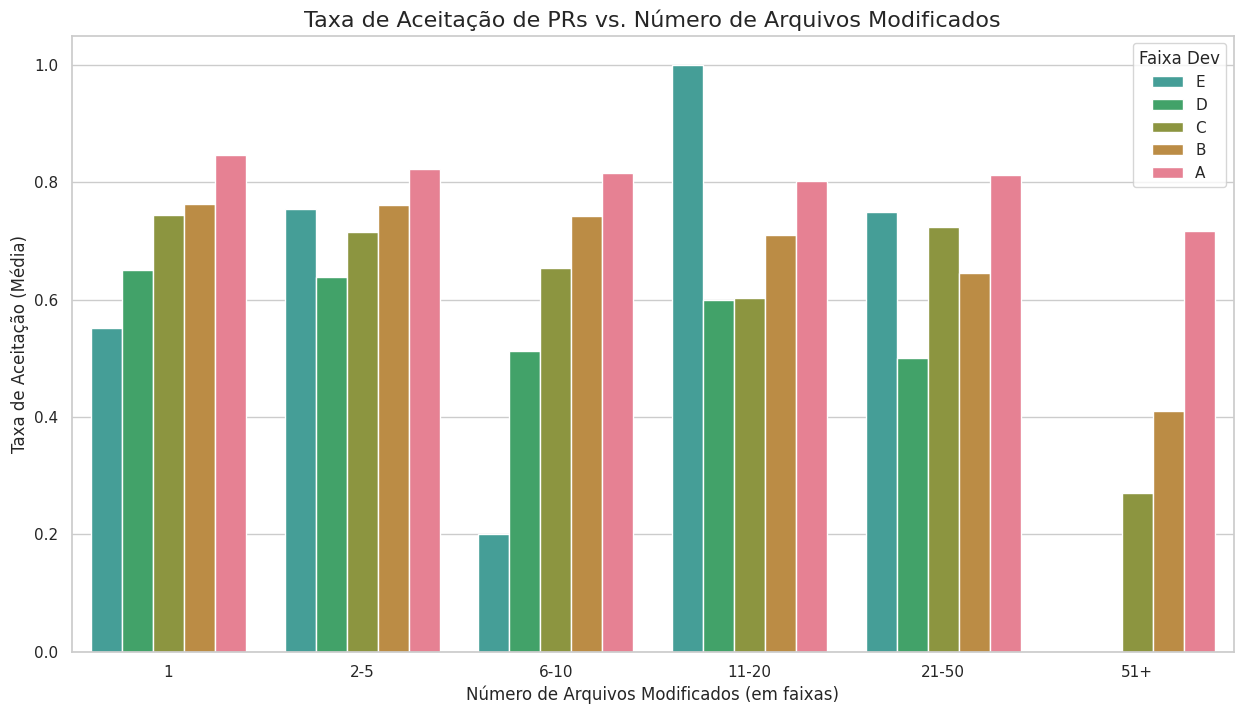


4. Analisando Taxa de Aceitação vs. Total de Linhas Modificadas...


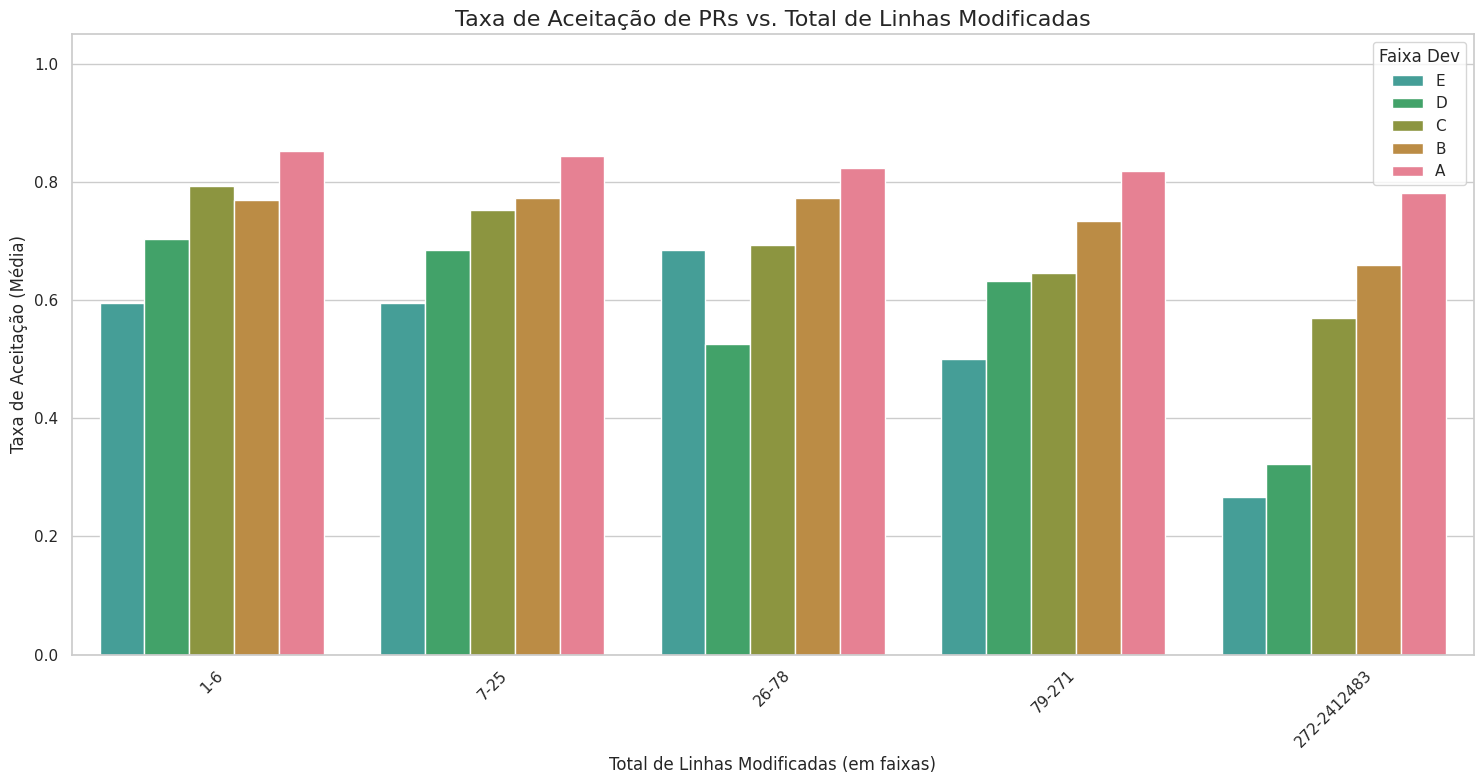

In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

BASE_DIR = 'repositories-mined'

def carregar_faixas_desenvolvedores(base_path):
    mapa_devs = {}
    print("1. Carregando classificação dos desenvolvedores...")
    if not os.path.exists(base_path):
        print(f"ERRO: O diretório base '{base_path}' não foi encontrado.")
        return None
    for repo_name in os.listdir(base_path):
        repo_path = os.path.join(base_path, repo_name)
        if not os.path.isdir(repo_path): continue
        devs_file = os.path.join(repo_path, 'sample-devs.jsonl')
        if os.path.exists(devs_file):
            with open(devs_file, 'r', encoding='utf-8') as f:
                for line in f:
                    data = json.loads(line)
                    key = (data['repo'].lower().replace('/', '-'), data['author'].lower())
                    mapa_devs[key] = data['faixa']
    print(f"-> Mapeamento de {len(mapa_devs)} desenvolvedores carregado.")
    return mapa_devs

def processar_todos_os_pull_requests(base_path, mapa_devs):
    """
    Processa TODOS os PRs (aceitos ou não) dos desenvolvedores da amostra.
    """
    dados_para_analise = []
    print("\n2. Processando TODOS os Pull Requests (aceitos e rejeitados)...")

    repo_list = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    for repo_name in tqdm(repo_list, desc="Repos"):
        devs_path = os.path.join(base_path, repo_name, 'developer')
        if not os.path.isdir(devs_path): continue
        for dev_name in os.listdir(devs_path):
            results_path = os.path.join(devs_path, dev_name, 'results')
            if not os.path.isdir(results_path): continue
            for pr_file in os.listdir(results_path):
                if pr_file.endswith('.json'):
                    pr_path = os.path.join(results_path, pr_file)
                    try:
                        with open(pr_path, 'r', encoding='utf-8') as f:
                            pr_data = json.load(f)

                        if pr_data.get('state') == 'closed':
                            repo_pr = pr_data.get('repo')
                            autor_pr = pr_data.get('author')
                            if not repo_pr or not autor_pr: continue

                            repo_normalizado = repo_pr.replace('/', '-')
                            chave_pr = (repo_normalizado.lower(), autor_pr.lower())

                            if chave_pr in mapa_devs:
                                faixa = mapa_devs[chave_pr]
                                aceito = 1 if pr_data.get('merged_at') is not None else 0
                                num_arquivos = pr_data.get('counts', {}).get('files', 0)
                                linhas_modificadas = 0
                                if 'files' in pr_data and pr_data['files'] is not None:
                                    for file_info in pr_data['files']:
                                        linhas_modificadas += file_info.get('additions', 0)
                                        linhas_modificadas += file_info.get('deletions', 0)

                                dados_para_analise.append({
                                    'faixa': faixa, 'num_arquivos': num_arquivos,
                                    'linhas_modificadas': linhas_modificadas, 'aceito': aceito
                                })
                    except (json.JSONDecodeError, KeyError) as e:
                        print(f"Aviso: Erro ao processar o arquivo {pr_path}. Ignorando. Erro: {e}")
                        continue
    print(f"-> Foram processados {len(dados_para_analise)} PRs fechados de desenvolvedores da amostra.")
    return pd.DataFrame(dados_para_analise)

# --- Bloco Principal de Execução ---
mapa_desenvolvedores = carregar_faixas_desenvolvedores(BASE_DIR)

if mapa_desenvolvedores is not None and mapa_desenvolvedores:
    df = processar_todos_os_pull_requests(BASE_DIR, mapa_desenvolvedores)

    if not df.empty:
        df['faixa'] = pd.Categorical(df['faixa'], categories=['A', 'B', 'C', 'D', 'E'], ordered=True)

        faixas_em_ordem_original = ['A', 'B', 'C', 'D', 'E']
        faixas_em_ordem_invertida = ['E', 'D', 'C', 'B', 'A']

        # --- MODIFICADO: Usando a paleta 'husl' conforme solicitado ---
        cores_paleta = sns.color_palette("husl", 8)
        paleta_consistente = dict(zip(faixas_em_ordem_original, cores_paleta))
        # --- FIM DA MODIFICAÇÃO ---

        # --- ANÁLISE 1: ACEITAÇÃO vs. NÚMERO DE ARQUIVOS ---
        print("\n3. Analisando Taxa de Aceitação vs. Número de Arquivos...")

        bins_arquivos = [0, 1, 5, 10, 20, 50, float('inf')]
        labels_arquivos = ['1', '2-5', '6-10', '11-20', '21-50', '51+']
        df['faixa_arquivos'] = pd.cut(df['num_arquivos'], bins=bins_arquivos, labels=labels_arquivos, right=True)

        taxa_aceitacao_arquivos = df.groupby(['faixa', 'faixa_arquivos'], observed=False)['aceito'].mean().reset_index()

        plt.figure(figsize=(15, 8))
        sns.barplot(data=taxa_aceitacao_arquivos, x='faixa_arquivos', y='aceito', hue='faixa',
                    palette=paleta_consistente, hue_order=faixas_em_ordem_invertida)
        plt.title('Taxa de Aceitação de PRs vs. Número de Arquivos Modificados', fontsize=16)
        plt.xlabel('Número de Arquivos Modificados (em faixas)')
        plt.ylabel('Taxa de Aceitação (Média)')
        plt.ylim(0, 1.05)
        plt.legend(title='Faixa Dev')
        plt.show()

        # --- ANÁLISE 2: ACEITAÇÃO vs. NÚMERO DE LINHAS ---
        print("\n4. Analisando Taxa de Aceitação vs. Total de Linhas Modificadas...")

        try:
            df_com_linhas = df[df['linhas_modificadas'] > 0].copy()
            df_com_linhas['faixa_linhas'] = pd.qcut(df_com_linhas['linhas_modificadas'], q=5, labels=False, duplicates='drop')
            qcut_labels = []
            for i in range(int(df_com_linhas['faixa_linhas'].max()) + 1):
                subset = df_com_linhas[df_com_linhas['faixa_linhas'] == i]
                min_val, max_val = subset['linhas_modificadas'].min(), subset['linhas_modificadas'].max()
                qcut_labels.append(f'{int(min_val)}-{int(max_val)}')
            df_com_linhas['faixa_linhas_label'] = df_com_linhas['faixa_linhas'].apply(lambda x: qcut_labels[int(x)] if pd.notna(x) else None)
            taxa_aceitacao_linhas = df_com_linhas.groupby(['faixa', 'faixa_linhas_label'], observed=False)['aceito'].mean().reset_index()
        except Exception as e:
            print(f"Não foi possível criar bins dinâmicos com qcut. Usando bins fixos. Erro: {e}")
            bins_linhas = [0, 10, 50, 200, 1000, float('inf')]
            labels_linhas = ['1-10', '11-50', '51-200', '201-1000', '1001+']
            df['faixa_linhas_label'] = pd.cut(df['linhas_modificadas'], bins=bins_linhas, labels=labels_linhas, right=True)
            taxa_aceitacao_linhas = df.groupby(['faixa', 'faixa_linhas_label'], observed=False)['aceito'].mean().reset_index()

        order = sorted(taxa_aceitacao_linhas['faixa_linhas_label'].unique(), key=lambda x: int(x.split('-')[0]))

        plt.figure(figsize=(15, 8))
        sns.barplot(data=taxa_aceitacao_linhas, x='faixa_linhas_label', y='aceito', hue='faixa',
                    palette=paleta_consistente, hue_order=faixas_em_ordem_invertida, order=order)
        plt.title('Taxa de Aceitação de PRs vs. Total de Linhas Modificadas', fontsize=16)
        plt.xlabel('Total de Linhas Modificadas (em faixas)')
        plt.ylabel('Taxa de Aceitação (Média)')
        plt.ylim(0, 1.05)
        plt.xticks(rotation=45)
        plt.legend(title='Faixa Dev')
        plt.tight_layout()
        plt.show()

Suspeitei de algum viés existente, pois a taxa de aceitação parece estar muito alta. Após analisar, a única fonte de viés possível é na própria eleição de repositórios (a eleição de devs parece estar correta): pode ser que os repositórios selecionados tenham uma taxa de aceitação muito alta.

1. Carregando classificação dos desenvolvedores...
-> Mapeamento de 975 desenvolvedores carregado.

2. Processando TODOS os Pull Requests (aceitos e rejeitados)...


Repos: 100%|██████████| 13/13 [00:02<00:00,  5.43it/s]
/tmp/ipykernel_26308/1105762070.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  corr_arquivos = df.groupby('faixa')['aceito'].corr(df['num_arquivos'])
/tmp/ipykernel_26308/1105762070.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  corr_linhas = df.groupby('faixa')['aceito'].corr(df['linhas_modificadas'])
/home/gustavo/Projects/versionamento-analise-dados/.venv/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warn

-> Foram processados 72801 PRs fechados de desenvolvedores da amostra.

3. Gerando gráfico de correlação com densidade: Aceitação vs. Nº de Arquivos


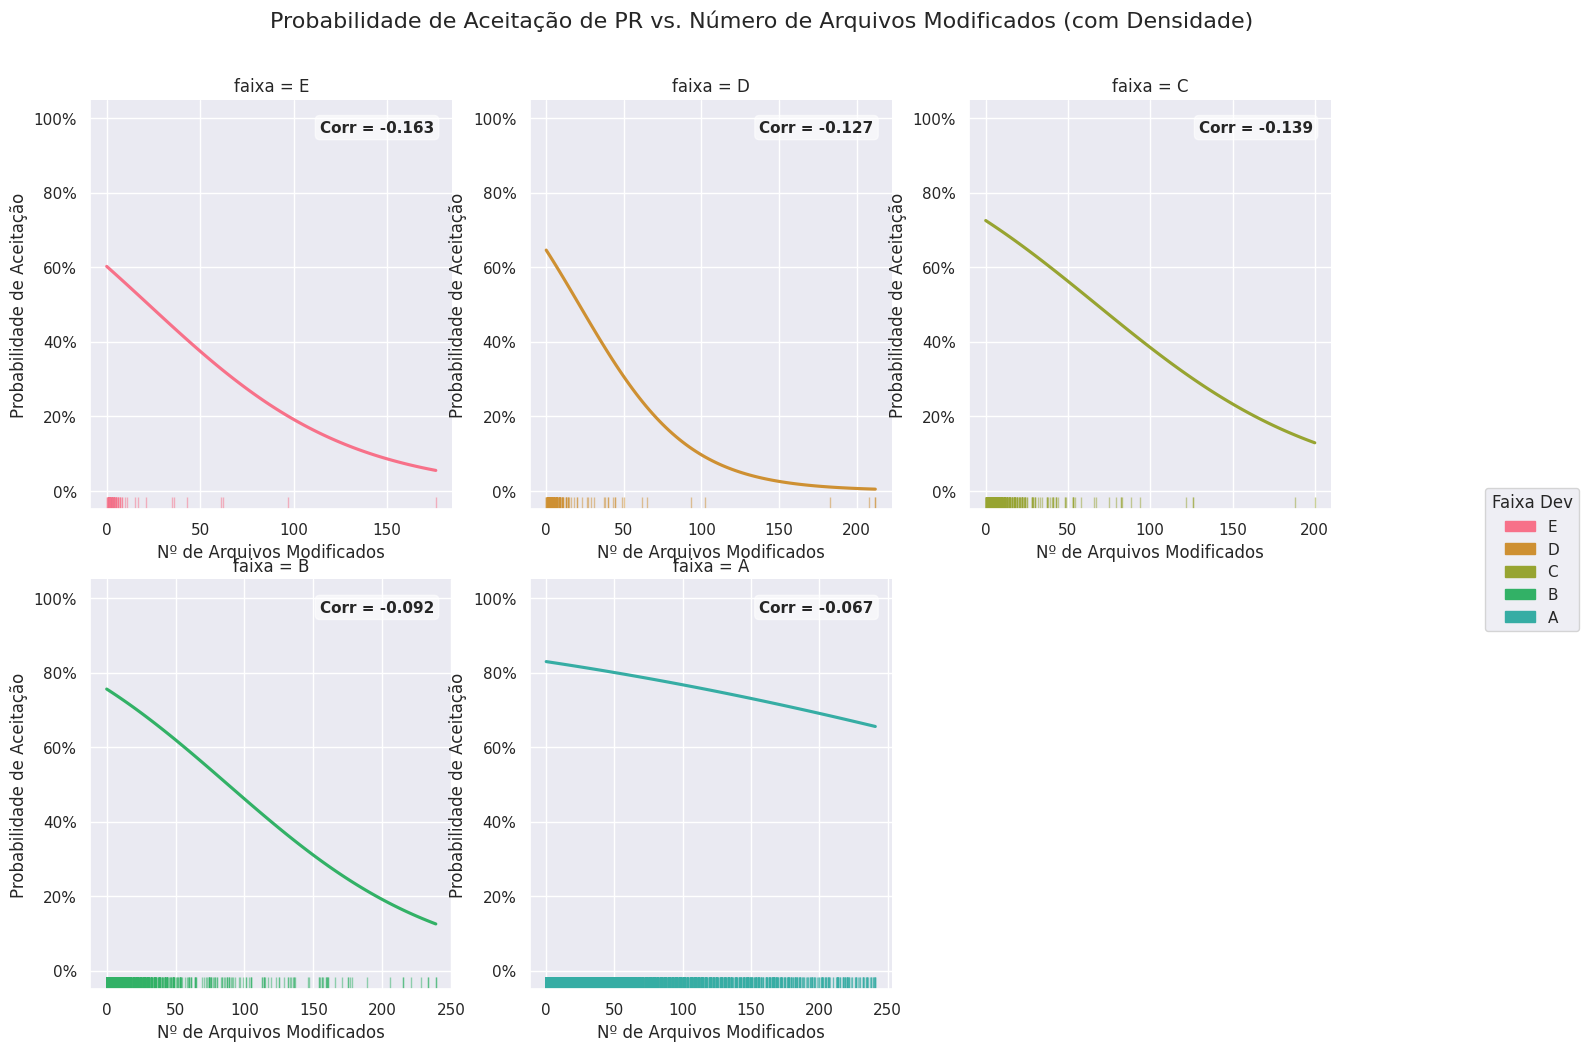


4. Gerando gráfico de correlação com densidade: Aceitação vs. Nº de Linhas


/home/gustavo/Projects/versionamento-analise-dados/.venv/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/gustavo/Projects/versionamento-analise-dados/.venv/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


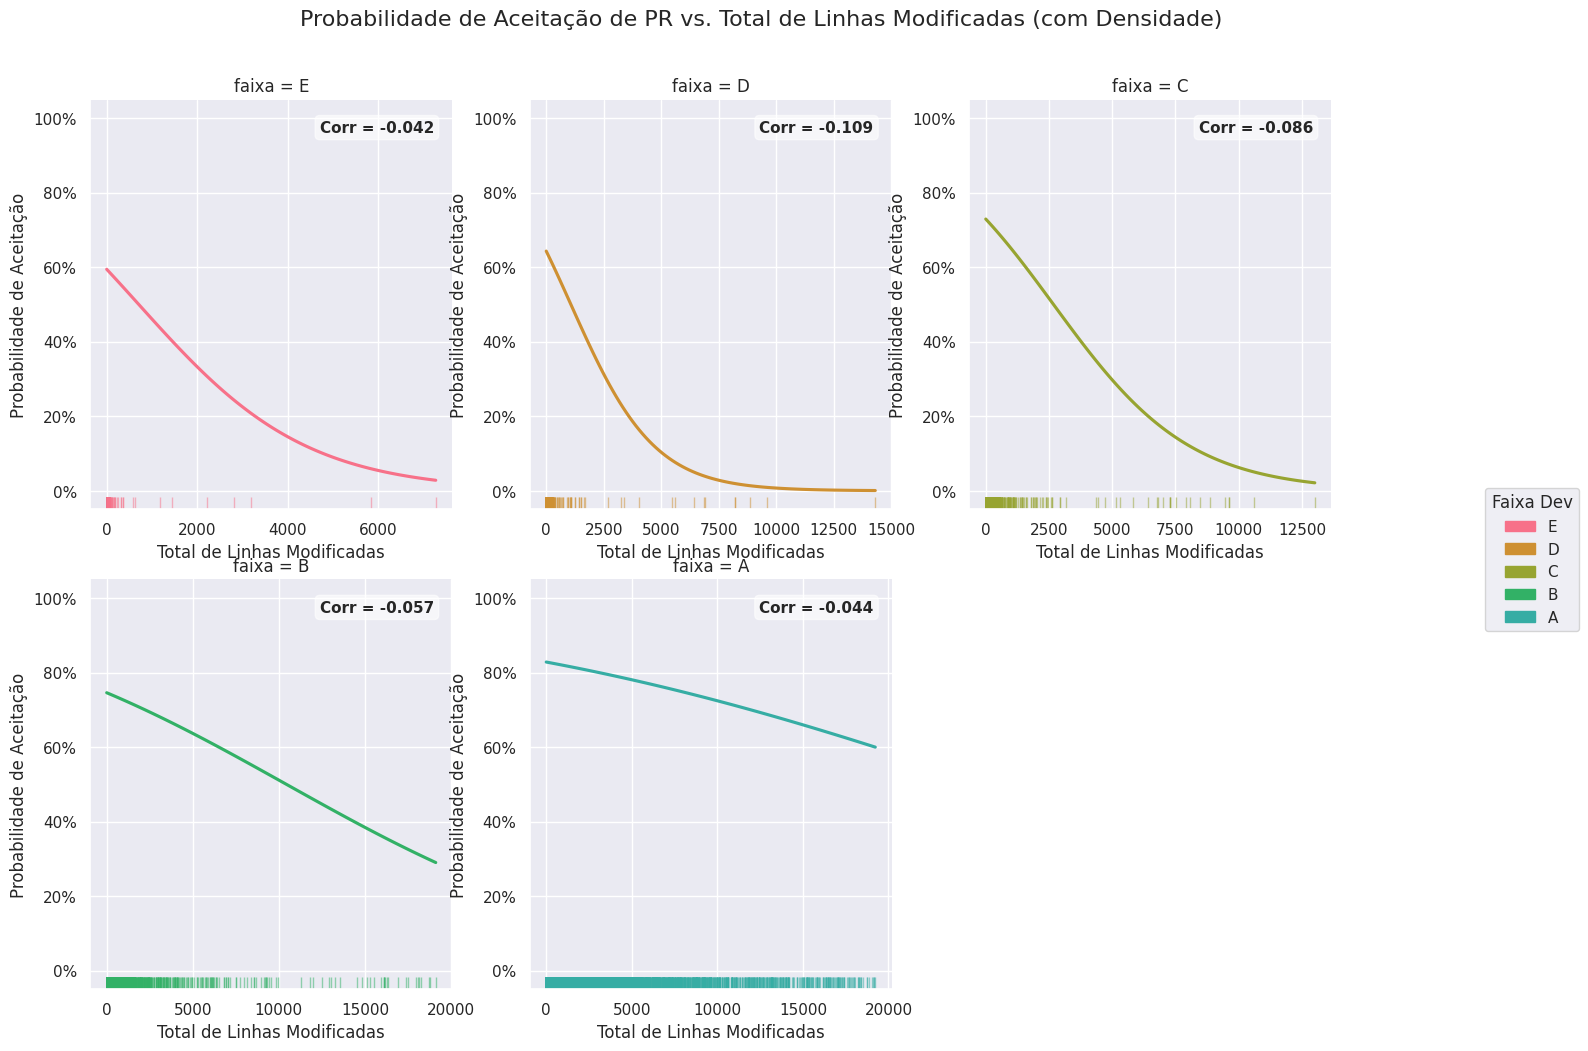

In [5]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Patch
from tqdm import tqdm

# --- 1. Configuração Inicial ---
BASE_DIR = 'repositories-mined'
FAIXA_ORDER_ORIGINAL = ['A', 'B', 'C', 'D', 'E']
# ALTERAÇÃO AQUI: Definindo a nova ordem para os gráficos
FAIXA_ORDER_GRAFICO = ['E', 'D', 'C', 'B', 'A']


# --- Funções de Carregamento e Processamento (sem alterações) ---
def carregar_faixas_desenvolvedores(base_path):
    mapa_devs = {}
    print("1. Carregando classificação dos desenvolvedores...")
    if not os.path.exists(base_path): return None
    for repo_name in os.listdir(base_path):
        repo_path = os.path.join(base_path, repo_name)
        if not os.path.isdir(repo_path): continue
        devs_file = os.path.join(repo_path, 'sample-devs.jsonl')
        if os.path.exists(devs_file):
            with open(devs_file, 'r', encoding='utf-8') as f:
                for line in f:
                    data = json.loads(line)
                    key = (data['repo'].lower().replace('/', '-'), data['author'].lower())
                    mapa_devs[key] = data['faixa']
    print(f"-> Mapeamento de {len(mapa_devs)} desenvolvedores carregado.")
    return mapa_devs


def processar_todos_os_pull_requests(base_path, mapa_devs):
    dados_para_analise = []
    print("\n2. Processando TODOS os Pull Requests (aceitos e rejeitados)...")
    repo_list = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    for repo_name in tqdm(repo_list, desc="Repos"):
        devs_path = os.path.join(base_path, repo_name, 'developer')
        if not os.path.isdir(devs_path): continue
        for dev_name in os.listdir(devs_path):
            results_path = os.path.join(devs_path, dev_name, 'results')
            if not os.path.isdir(results_path): continue
            for pr_file in os.listdir(results_path):
                if pr_file.endswith('.json'):
                    pr_path = os.path.join(results_path, pr_file)
                    try:
                        with open(pr_path, 'r', encoding='utf-8') as f:
                            pr_data = json.load(f)
                        if pr_data.get('state') == 'closed':
                            repo_pr, autor_pr = pr_data.get('repo'), pr_data.get('author')
                            if not repo_pr or not autor_pr: continue
                            repo_normalizado = repo_pr.replace('/', '-')
                            chave_pr = (repo_normalizado.lower(), autor_pr.lower())
                            if chave_pr in mapa_devs:
                                faixa = mapa_devs[chave_pr]
                                aceito = 1 if pr_data.get('merged_at') is not None else 0
                                num_arquivos = pr_data.get('counts', {}).get('files', 0)
                                linhas_modificadas = sum(
                                    f.get('additions', 0) + f.get('deletions', 0) for f in pr_data.get('files', []))
                                dados_para_analise.append({'faixa': faixa, 'num_arquivos': num_arquivos,
                                                           'linhas_modificadas': linhas_modificadas, 'aceito': aceito})
                    except (json.JSONDecodeError, KeyError) as e:
                        print(f"Aviso: Erro ao processar o arquivo {pr_path}. Ignorando. Erro: {e}")
                        continue
    print(f"-> Foram processados {len(dados_para_analise)} PRs fechados de desenvolvedores da amostra.")
    return pd.DataFrame(dados_para_analise)


# --- BLOCO PRINCIPAL DE EXECUÇÃO ---
mapa_desenvolvedores = carregar_faixas_desenvolvedores(BASE_DIR)

if mapa_desenvolvedores:
    df = processar_todos_os_pull_requests(BASE_DIR, mapa_desenvolvedores)
    if not df.empty:
        # ALTERAÇÃO AQUI: Usa a nova ordem para definir a categoria no DataFrame
        df['faixa'] = pd.Categorical(df['faixa'], categories=FAIXA_ORDER_GRAFICO, ordered=True)

        corr_arquivos = df.groupby('faixa')['aceito'].corr(df['num_arquivos'])
        corr_linhas = df.groupby('faixa')['aceito'].corr(df['linhas_modificadas'])

        cores_husl = sns.color_palette("husl", 8)
        # ALTERAÇÃO AQUI: Usa a nova ordem para criar a paleta de cores
        paleta_consistente = dict(zip(FAIXA_ORDER_GRAFICO, cores_husl))

        # --- ANÁLISE VISUAL 1: ACEITAÇÃO vs. NÚMERO DE ARQUIVOS ---
        print("\n3. Gerando gráfico de correlação com densidade: Aceitação vs. Nº de Arquivos")
        limite_arquivos = df['num_arquivos'].quantile(0.99)
        df_filtrado_arquivos = df[df['num_arquivos'] <= limite_arquivos]

        # ALTERAÇÃO AQUI: Usa a nova ordem nos parâmetros col_order e hue_order
        g = sns.lmplot(data=df_filtrado_arquivos, x='num_arquivos', y='aceito', col='faixa',
                       col_order=FAIXA_ORDER_GRAFICO, hue='faixa', palette=paleta_consistente,
                       hue_order=FAIXA_ORDER_GRAFICO, logistic=True, scatter=False, ci=None, height=5, aspect=1,
                       col_wrap=3, legend=False, sharex=False, sharey=False)
        g.fig.suptitle('Probabilidade de Aceitação de PR vs. Número de Arquivos Modificados (com Densidade)', y=1.05,
                       fontsize=16)

        for i, ax in enumerate(g.axes.flat):
            if not ax.has_data(): continue
            # ALTERAÇÃO AQUI: Mapeia o índice para a faixa usando a nova ordem
            faixa = FAIXA_ORDER_GRAFICO[i]

            # --- INÍCIO DA MODIFICAÇÃO: ADICIONANDO O RUG PLOT ---
            dados_faixa = df_filtrado_arquivos[df_filtrado_arquivos['faixa'] == faixa]
            sns.rugplot(data=dados_faixa, x='num_arquivos', ax=ax, color=ax.lines[0].get_color(), height=0.03,
                        alpha=0.5)
            # --- FIM DA MODIFICAÇÃO ---

            corr_val = corr_arquivos.get(faixa)
            if pd.notna(corr_val):
                ax.text(0.95, 0.95, f"Corr = {corr_val:.3f}", transform=ax.transAxes, fontsize=11, fontweight='bold',
                        verticalalignment='top', horizontalalignment='right',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.6))

            ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
            ax.set_ylim(-0.05, 1.05)
            ax.set_ylabel('Probabilidade de Aceitação')
            ax.set_xlabel('Nº de Arquivos Modificados')

        legend_patches = [Patch(color=color, label=faixa) for faixa, color in paleta_consistente.items()]
        g.fig.legend(handles=legend_patches, title='Faixa Dev', loc='center right', bbox_to_anchor=(1.05, 0.5))
        plt.subplots_adjust(right=0.88)
        plt.show()

        # --- ANÁLISE VISUAL 2: ACEITAÇÃO vs. NÚMERO DE LINHAS ---
        print("\n4. Gerando gráfico de correlação com densidade: Aceitação vs. Nº de Linhas")
        limite_linhas = df['linhas_modificadas'].quantile(0.99)
        df_filtrado_linhas = df[df['linhas_modificadas'] <= limite_linhas]

        # ALTERAÇÃO AQUI: Usa a nova ordem nos parâmetros col_order e hue_order
        g = sns.lmplot(data=df_filtrado_linhas, x='linhas_modificadas', y='aceito', col='faixa',
                       col_order=FAIXA_ORDER_GRAFICO, hue='faixa', palette=paleta_consistente,
                       hue_order=FAIXA_ORDER_GRAFICO, logistic=True, scatter=False, ci=None, height=5, aspect=1,
                       col_wrap=3, legend=False, sharex=False, sharey=False)
        g.fig.suptitle('Probabilidade de Aceitação de PR vs. Total de Linhas Modificadas (com Densidade)', y=1.05,
                       fontsize=16)

        for i, ax in enumerate(g.axes.flat):
            if not ax.has_data(): continue
            # ALTERAÇÃO AQUI: Mapeia o índice para a faixa usando a nova ordem
            faixa = FAIXA_ORDER_GRAFICO[i]

            # --- INÍCIO DA MODIFICAÇÃO: ADICIONANDO O RUG PLOT ---
            dados_faixa = df_filtrado_linhas[df_filtrado_linhas['faixa'] == faixa]
            sns.rugplot(data=dados_faixa, x='linhas_modificadas', ax=ax, color=ax.lines[0].get_color(), height=0.03,
                        alpha=0.5)
            # --- FIM DA MODIFICAÇÃO ---

            corr_val = corr_linhas.get(faixa)
            if pd.notna(corr_val):
                ax.text(0.95, 0.95, f"Corr = {corr_val:.3f}", transform=ax.transAxes, fontsize=11, fontweight='bold',
                        verticalalignment='top', horizontalalignment='right',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.6))

            ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
            ax.set_ylim(-0.05, 1.05)
            ax.set_ylabel('Probabilidade de Aceitação')
            ax.set_xlabel('Total de Linhas Modificadas')

        legend_patches = [Patch(color=color, label=faixa) for faixa, color in paleta_consistente.items()]
        g.fig.legend(handles=legend_patches, title='Faixa Dev', loc='center right', bbox_to_anchor=(1.05, 0.5))
        plt.subplots_adjust(right=0.88)
        plt.show()